### Looking at cluster consistency

After clustering some data, you often want to (and should!) inspect the results. Obviously, visualization is a big part of this. It is also helpful to look at some representative examples. HDBSCAN provides methods to get an approximate representative point for each cluster. It does this by calculating the centroid/medoid for each cluster, but weighting each point by its cluster membership strength (i.e. the probability of being in that cluster). One way to get representative samples for a cluster is to look for the points closest and furthest to this representative point. This allows you to look at the cluster and determine how consistent it is. For example, when clustering text this might mean "are the documents in my cluster talking about one topic?". 

Let's get some test data and cluster it:

In [1]:
import pandas as pd
import numpy as np
import hdbscan
from scipy.spatial.distance import cdist
#Some plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}

In [2]:
data = np.load('clusterable_data.npy')

In [3]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(data)
labels = clusterer.labels_

Now let's plot our sample data. We will see that the clustering is pretty good.

<IPython.core.display.Javascript object>


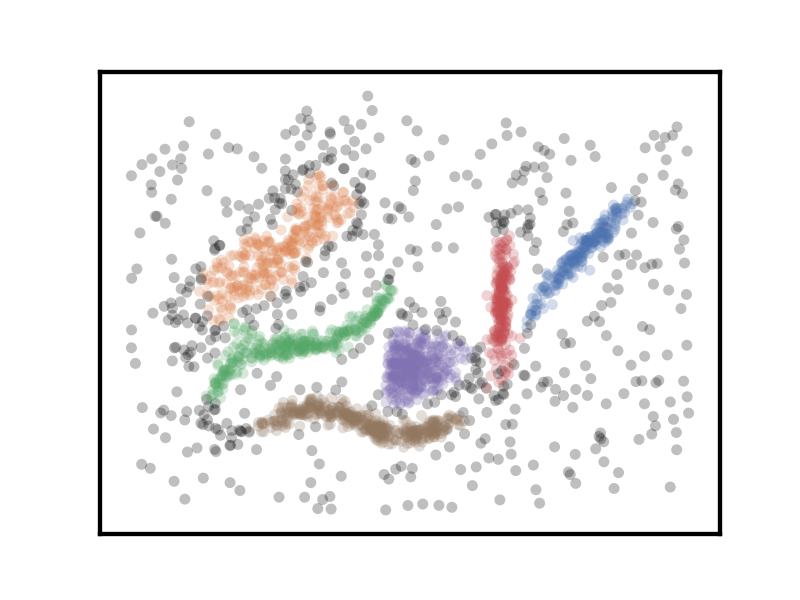

In [4]:
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


### Finding representative points

Below is a class that you can use to find the points closest to and furthest away from the cluster centroids/medoids.

In [5]:
class RankedPoints:
    
    def __init__(self, points, clusterer, metric='euclidean', selection_method='centroid'):
        """ Rank points in a cluster based on their distance to the cluster centroid/medoid
        
        Parameters
        ----------
        
        points : array of shape (n_samples, n_features), and must be the same data passed into
                 HDBSCAN
        
        clusterer : Instance of HDBSCAN that has been fit to data
        
        metric: string or callable, optional (default='euclidean')
            The metric to use when calculating distance between points in a cluster and 
            the cluster centroid/medoid. If metric is a string or callable, it must be one of
            the options allowed by scipy.spatial.distance.cdist for its metric parameter.
        
        selection_method: string, optional (default='centroid')
            Method to use to find the weighted cluster center. Allowed options are 'centroid' 
            and 'medoid'.
        
        """
        self.clusterer = clusterer
        self.metric = metric
        
        allowed_methods = ['centroid', 'medoid']
        if selection_method not in allowed_methods:
            raise ValueError(f'Selection method must be one of {allowed_methods}')
        
        if selection_method == 'centroid' and metric != 'euclidean':
            raise ValueError(f'Metric must be euclidian when using selection_method centroid. '
                             f'Current metric is {metric}')
        
        self.selection_method = selection_method
        
        self._embedding_cols = [str(i) for i in range(points.shape[1])]
        self.embedding_df = pd.DataFrame(points, columns=self._embedding_cols)
        self.embedding_df['cluster'] = clusterer.labels_
    
    def calculate_all_distances_to_center(self):
        """For each cluster calculate the distance from each point to the centroid/medoid"""
        all_distances = pd.DataFrame()
        for label in np.unique(self.embedding_df['cluster']):           
            distance_df = self.calculate_distances_for_cluster(label)
            all_distances = pd.concat([all_distances, distance_df])
        
        self.embedding_df = self.embedding_df.merge(all_distances, left_index=True, right_index=True)
    
    def calculate_distances_for_cluster(self, cluster_id):
        """For a given cluster_id calculate the distance from each point to the centroid/medoid.
        
        Parameters
        ----------

        cluster_id : int
            The id of the cluster to compute the distances for. If the cluster id is -1 which
            corresponds to the noise point cluster, then this will return a distance of NaN.

        Returns
        -------

        df : A pandas DataFrame containing the distances from each point to the cluster centroid/medoid.
             The index of the dataframe corresponds to the index in the original data. 

        """
        cluster_of_interest = self.embedding_df[self.embedding_df['cluster'] == cluster_id].copy()
        
        if cluster_of_interest.empty:
            raise ValueError(f'Cluster id {cluster_id} not found')
        
        # Don't calculate distances for the noise cluster
        if cluster_id == -1:
            return pd.DataFrame(np.nan, columns=['dist_to_rep_point'], index=cluster_of_interest.index)
        
        if self.selection_method == 'centroid':
            rep_point = self.clusterer.weighted_cluster_centroid(cluster_id)
        if self.selection_method == 'medoid':
            rep_point = self.clusterer.weighted_cluster_medoid(cluster_id)
        
        dists = cdist(rep_point.reshape((1,len(self._embedding_cols))), cluster_of_interest[self._embedding_cols].values, metric=self.metric)
        return pd.DataFrame(dists[0], columns=['dist_to_rep_point'], index=cluster_of_interest.index)
    
    def rank_cluster_points_by_distance(self, cluster_id):
        """For a given cluster return a pandas dataframe of points ranked 
           by distance to the cluster centroid/medoid
        """
        cluster_of_interest = self.embedding_df[self.embedding_df['cluster'] == cluster_id].copy()
        
        if cluster_of_interest.empty:
            raise ValueError(f'Cluster id {cluster_id} not found')
            
        if 'dist_to_rep_point' not in self.embedding_df.columns:
            distance_df = self.calculate_distances_for_cluster(cluster_id)
            cluster_of_interest = cluster_of_interest.merge(distance_df, left_index=True, right_index=True)
        
        cluster_of_interest.sort_values('dist_to_rep_point', inplace=True)
        return cluster_of_interest
    
    def get_closest_samples_for_cluster(self, cluster_id, n_samples=5):
        """Get the N closest points to the cluster centroid/medoid"""
        return self.rank_cluster_points_by_distance(cluster_id).head(n_samples)
    
    def get_furthest_samples_for_cluster(self, cluster_id, n_samples=5):
        """Get the N points furthest away from the cluster centroid/medoid"""
        return self.rank_cluster_points_by_distance(cluster_id).tail(n_samples)
        

To use it we first need to instantiate the class. We pass in our sample data and the pretrained HDBSCAN class instance.

In [6]:
examples = RankedPoints(data, clusterer, metric='euclidean', selection_method='medoid')

You can calculate the distances to the center for all clusters

In [9]:
examples.calculate_all_distances_to_center()

Or just one

In [16]:
distance_to_cluster_1_center = examples.calculate_distances_for_cluster(1)
distance_to_cluster_1_center

,dist_to_rep_point
1200,0.185616
1201,0.061235
1202,0.225697
1205,0.033554
1206,0.025164
...,...
2194,0.098091
2220,0.054152
2268,0.200824
2272,0.124824


Perhaps more usefully, you can get a list of points ranked based on their distance

In [17]:
cluster_1_ranked = examples.rank_cluster_points_by_distance(1)
cluster_1_ranked

,0,1,cluster,dist_to_rep_point
1582,-0.207633,0.230794,1,0.000000
1565,-0.209338,0.235881,1,0.005365
1448,-0.214983,0.231339,1,0.007371
1540,-0.202308,0.222834,1,0.009577
1219,-0.204521,0.240115,1,0.009827
...,...,...,...,...
1291,-0.322111,0.037692,1,0.224486
1451,-0.124656,0.439562,1,0.224653
1202,-0.319037,0.034508,1,0.225697
1469,-0.126015,0.445464,1,0.229662


### Getting the N "most/least representative" points for a cluster

There are a couple of wrapper methods to get the N points closest/furthest to the cluster center. All of these methods will return a dataframe with the index corresponding to the original data. This makes it easy to merge back with your original data and enrich it with other features.

In [10]:
examples.get_closest_samples_for_cluster(2, n_samples=5)

,0,1,cluster,dist_to_rep_point
1645,-0.164494,-0.036982,2,0.000000
1701,-0.161733,-0.039066,2,0.003460
1840,-0.164663,-0.042350,2,0.005371
1812,-0.158787,-0.035200,2,0.005979
1679,-0.165111,-0.030426,2,0.006585


In [11]:
examples.get_furthest_samples_for_cluster(2, n_samples=5)

,0,1,cluster,dist_to_rep_point
1620,0.014810,0.119051,2,0.237690
1733,0.015830,0.119390,2,0.238682
1632,0.008484,0.129942,2,0.240385
1792,0.003510,0.135245,2,0.240598
1671,0.019809,0.118011,2,0.240812


We can get these points for all clusters and put them into a dataframe for plotting

In [12]:
close_samples = pd.DataFrame()
far_samples = pd.DataFrame()

for cluster in pd.unique(clusterer.labels_):
    if cluster >=0:
        close_samples = pd.concat([close_samples, examples.get_closest_samples_for_cluster(cluster)])
        far_samples = pd.concat([far_samples, examples.get_furthest_samples_for_cluster(cluster)])

In [13]:
close_samples.head()

,0,1,cluster,dist_to_rep_point
5,-0.031930,-0.256859,5,0.000000
106,-0.032453,-0.258743,5,0.001956
116,-0.033843,-0.255187,5,0.002540
297,-0.026987,-0.260578,5,0.006185
28,-0.023922,-0.256170,5,0.008037


In [14]:
far_samples.head()

,0,1,cluster,dist_to_rep_point
189,-0.238119,-0.253511,5,0.206217
160,-0.238388,-0.278419,5,0.207581
42,-0.244433,-0.252980,5,0.212539
146,-0.244435,-0.263221,5,0.212601
117,-0.262338,-0.275841,5,0.231189


Let's make the same plot from before but add black stars for the "most representative" points and blue X's for the "least representative" points

<IPython.core.display.Javascript object>


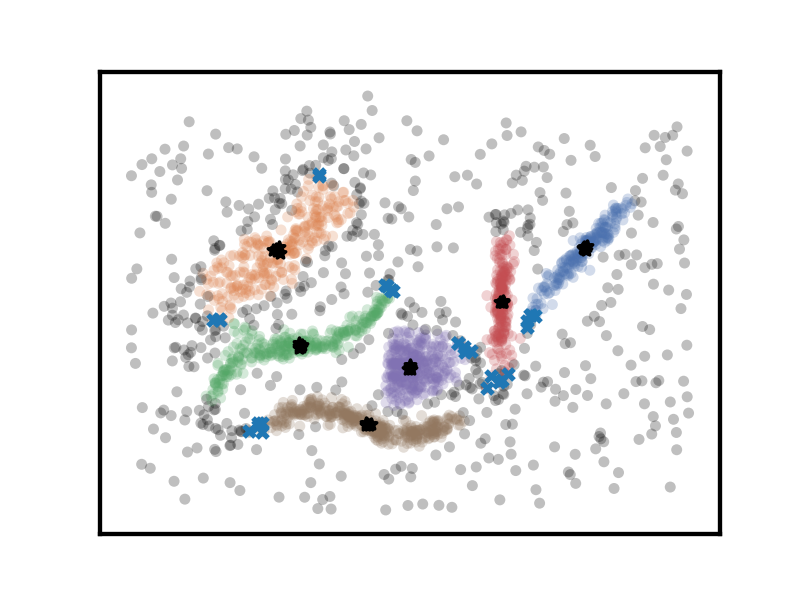

In [15]:
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
ax1.scatter(close_samples['0'], close_samples['1'], s=40, marker='*', c=[(0.0,0.0,0.0)])
ax1.scatter(far_samples['0'], far_samples['1'], s=40, marker='x')

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


As you can see this does what we would expect. This is a fairly crude method but can be useful when doing exploratory data analysis.